In [1]:
# Packages
import pandas as pd
import pickle
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import pickle

# XGB

In [2]:
df = pickle.load(open('../data/data_full.pkl', 'rb'))

In [3]:
df.head()

,demand,temp_bath,temp_liverpool,temp_london,pressure_bath,pressure_liverpool,pressure_london,humidity_bath,humidity_liverpool,humidity_london,wind_speed_bath,wind_speed_liverpool,wind_speed_london,clouds_all_bath,clouds_all_liverpool,clouds_all_london
2020-12-01 00:00:00+00:00,26812.0,280.700,279.15,280.21,1025.0,1024.0,1022.0,81.0,80.0,73.0,1.790,4.60,4.1,98.0,0.0,0.0
2020-12-01 00:30:00+00:00,26886.0,280.245,279.25,279.87,1025.0,1024.0,1022.0,81.0,79.0,74.0,2.845,4.35,4.6,97.0,0.0,0.0
2020-12-01 01:00:00+00:00,26473.0,279.790,279.35,279.53,1025.0,1024.0,1022.0,81.0,78.0,75.0,3.900,4.10,5.1,96.0,0.0,0.0
2020-12-01 01:30:00+00:00,26105.0,279.365,279.18,279.38,1025.0,1024.5,1022.5,82.0,79.0,75.0,3.790,4.10,5.4,96.5,0.0,0.0
2020-12-01 02:00:00+00:00,25861.0,278.940,279.01,279.23,1025.0,1025.0,1023.0,83.0,80.0,75.0,3.680,4.10,5.7,97.0,0.0,0.0


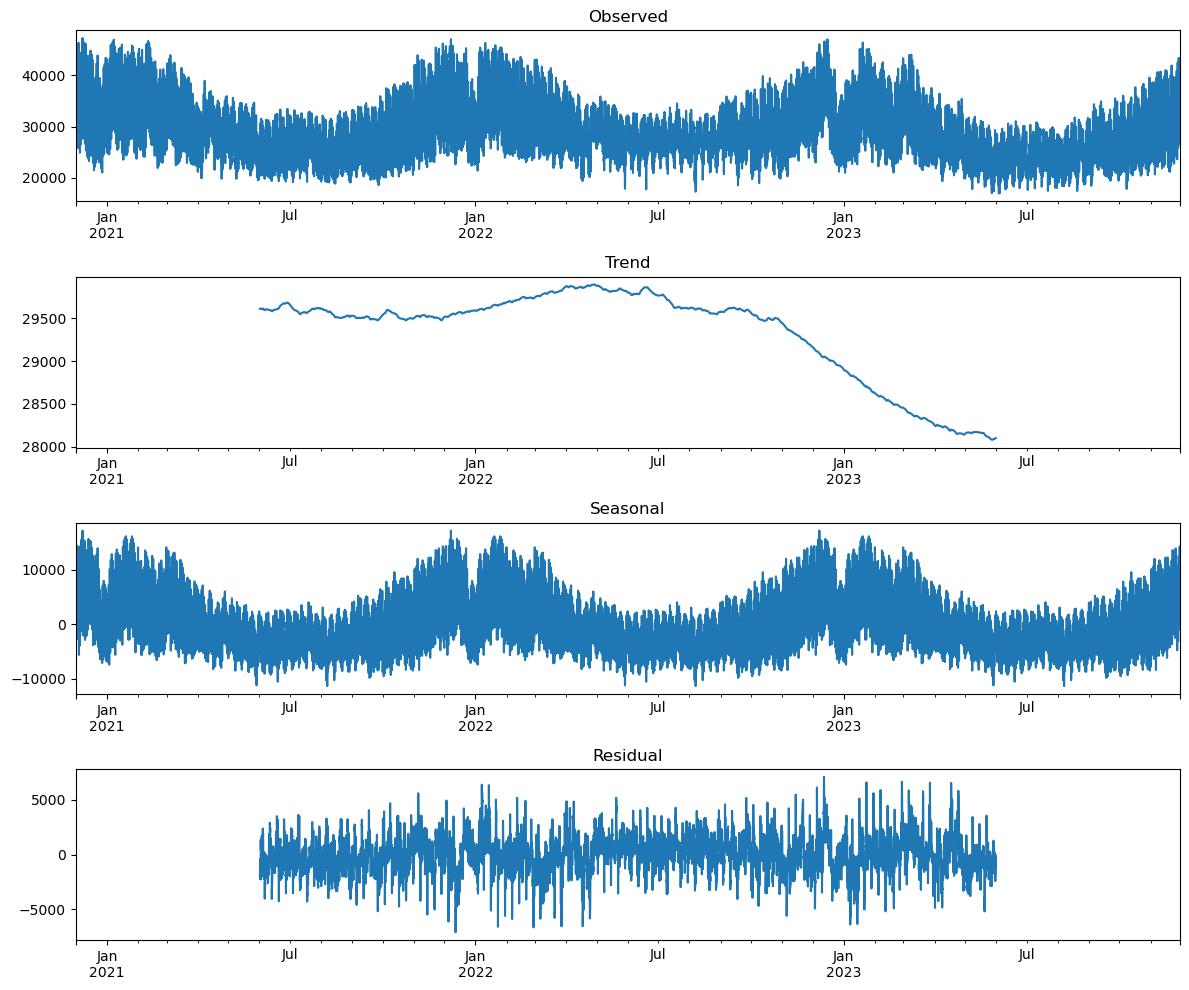

In [49]:
# Decomposing daily, weekly and yearly seasonality
decomposition_daily = seasonal_decompose(df['demand'], model='additive', period=48*365)

# Plotting the decomposed components for the daily data
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))
decomposition_daily.observed.plot(ax=ax1, title='Observed')
decomposition_daily.trend.plot(ax=ax2, title='Trend')
decomposition_daily.seasonal.plot(ax=ax3, title='Seasonal')
decomposition_daily.resid.plot(ax=ax4, title='Residual')
plt.tight_layout()
plt.show()

In [4]:
df['DATETIME'] = df.index
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
df = df.asfreq('30T')

df['year'] = df['DATETIME'].dt.year
df['month'] = df['DATETIME'].dt.month
df['day'] = df['DATETIME'].dt.day
df['hour'] = df['DATETIME'].dt.hour
df['min'] = df['DATETIME'].dt.minute
df = df.drop(['DATETIME'], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52513 entries, 2020-12-01 00:00:00+00:00 to 2023-11-30 00:00:00+00:00
Freq: 30T
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   demand                52513 non-null  float64
 1   temp_bath             52513 non-null  float64
 2   temp_liverpool        52513 non-null  float64
 3   temp_london           52513 non-null  float64
 4   pressure_bath         52513 non-null  float64
 5   pressure_liverpool    52513 non-null  float64
 6   pressure_london       52513 non-null  float64
 7   humidity_bath         52513 non-null  float64
 8   humidity_liverpool    52513 non-null  float64
 9   humidity_london       52513 non-null  float64
 10  wind_speed_bath       52513 non-null  float64
 11  wind_speed_liverpool  52513 non-null  float64
 12  wind_speed_london     52513 non-null  float64
 13  clouds_all_bath       52513 non-null  float64
 14  clouds_all_li

In [5]:
X = df.drop('demand', axis=1)
y = df['demand']  

tscv = TimeSeriesSplit(n_splits=6)

In [92]:
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 400]
}

In [101]:
random_search.best_params_

{'subsample': 1.0,
 'n_estimators': 100,
 'min_child_weight': 5,
 'max_depth': 5,
 'learning_rate': 0.2,
 'gamma': 0,
 'colsample_bytree': 0.6}

In [93]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, 
                                   n_iter=100, cv=tscv, verbose=2, n_jobs=-1, 
                                   scoring='neg_mean_squared_error')

In [94]:
random_search.fit(X, y)

Fitting 6 folds for each of 100 candidates, totalling 600 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=6, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=No...
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 5, 7, 10],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 300, 400],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='neg_mean_squared_error', verbose=2)

In [95]:
best_model = random_search.best_estimator_

y_pred = best_model.predict(X)

In [ ]:
mse = mean_squared_error(y, y_pred, squared=False)
r2 = r2_score(y, y_pred)
print(f"RMSE: {mse}")
print(f"R2 Score: {r2}")

Mean Squared Error: 1759.1048148519285
R2 Score: 0.9042442805018052


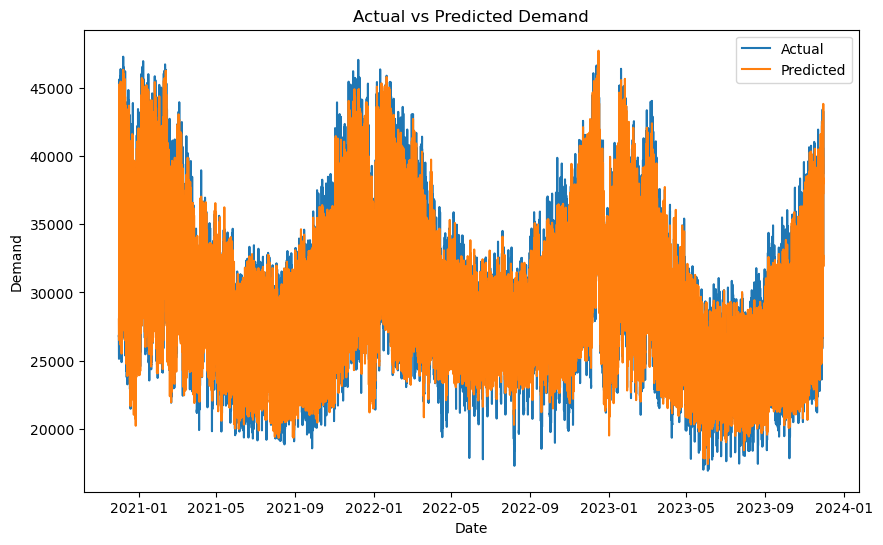

In [97]:
plt.figure(figsize=(10, 6))
plt.plot(y.index, y, label='Actual')
plt.plot(y.index, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Actual vs Predicted Demand')
plt.legend()
plt.show()

In [6]:
param_grid = {
    'max_depth': [5],
    'min_child_weight': [5],
    'gamma': [0],
    'subsample': [1.0],
    'colsample_bytree': [0.6],
    'learning_rate': [0.2],
    'n_estimators': [100]
}

In [7]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Set up GridSearchCV
grid_search = GridSearchCV(xgb_model, param_grid=param_grid, cv=tscv, verbose=2, n_jobs=-1, 
                           scoring='neg_mean_squared_error')

In [8]:
grid_search.fit(X, y)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X)

Fitting 6 folds for each of 1 candidates, totalling 6 fits


In [9]:
grid_search.best_params_

{'colsample_bytree': 0.6,
 'gamma': 0,
 'learning_rate': 0.2,
 'max_depth': 5,
 'min_child_weight': 5,
 'n_estimators': 100,
 'subsample': 1.0}

In [14]:
mse = mean_squared_error(y, y_pred, squared=False)
r2 = r2_score(y, y_pred)

print(f"RMSE: {mse}")
print(f"R2 Score: {r2}")

RMSE: 1759.1048148519285
R2 Score: 0.9042442805018052


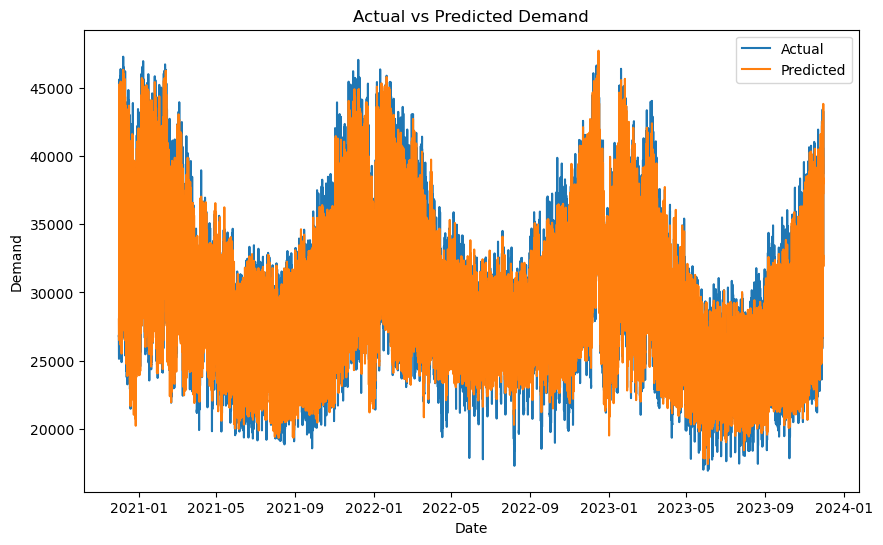

In [114]:
plt.figure(figsize=(10, 6))
plt.plot(y.index, y, label='Actual')
plt.plot(y.index, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Actual vs Predicted Demand')
plt.legend()
plt.show()

In [ ]:
best_model

In [116]:
filename = 'XGB_model.sav'
pickle.dump(best_model, open('../models_sav' + filename, 'wb'))